# 1. Libraries for all cells

In [2]:
import os
import pandas as pd
import copy
from pdf2image import convert_from_path
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models
from tqdm import tqdm
import re
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from pdf2image import convert_from_path


In [4]:
CSV_FILE       = "/kaggle/input/musicsheets/preprocessed_images/dataset.csv"        # csv with 'primary_genre' and 'pdf' columns
PDF_FOLDER     = "/kaggle/input/musicsheets/preprocessed_images/preprocessed_images/"       # folder containing PDF files
IMG_SIZE       = (512, 512)
BATCH_SIZE     = 32
VAL_SPLIT      = 0.1
NUM_EPOCHS     = 1
LEARNING_RATE  = 0.0005
RANDOM_SEED    = 42
UNFROZEN_LAYERS = 3
torch.manual_seed(RANDOM_SEED)
g = torch.Generator() # for DataLoader shuffling
g.manual_seed(42)  # for same splits of data

# 2. Data loading pipeline

### 2.1 Read CSV

In [5]:
df = pd.read_csv(CSV_FILE)

In [6]:
# Get unique genres
unique_genres = df["primary_genre"].unique()
# We create mapping for string labels to ints
genre_to_idx  = {genre: idx for idx, genre in enumerate(unique_genres)}
idx_to_genre  = {idx: genre for genre, idx in genre_to_idx.items()}

num_classes = len(genre_to_idx)
print("Discovered classes:", genre_to_idx)

Discovered classes: {'Classical': 0, 'Electronic & Dance': 1, 'Folk/World': 2, 'Pop': 3, 'R&B, Soul & Hip-Hop': 4, 'Religious': 5, 'Rock & Metal': 6, 'Soundtrack': 7}


### 2.2 PDF to PNG

In [ ]:
# IMAGE_DIR = "/kaggle/working/preprocessed_imagess/"  # folder to store preprocessed images

# # Ensure output directory exists
# os.makedirs(IMAGE_DIR, exist_ok=True)

# required_pdfs = set(df["pdf"].str.strip().apply(lambda x: os.path.basename(x)))  # only filename (no path)
# print("Preprocessing PDFs into images...")

# for root, _, files in os.walk(PDF_FOLDER):
#     for pdf_file in files:
#         pdf_file_cleaned = pdf_file.strip()  # no extra spaces
#         if pdf_file_cleaned.endswith(".pdf") and pdf_file_cleaned in required_pdfs:  # file in pdf folder but also has path in csv
#             pdf_path = os.path.join(root, pdf_file_cleaned)
#             images = convert_from_path(pdf_path)  # convert 
#             img_save_path = os.path.join(IMAGE_DIR, pdf_file_cleaned.replace(".pdf", ".png"))
#             images[0].save(img_save_path, "PNG")
#             print(f"Saved: {img_save_path}")

# print("PDF to PNG conversion complete!!!!!!")


### 2.3 Dataset class creation

In [7]:
class SheetMusicImageDataset(Dataset):
    """
    Reads a CSV with columns: 'primary_genre', 'pdf' (originally).
    Now, it loads the corresponding PNG directly from a folder.
    """
    def __init__(self, csv_path, png_folder, transform=None, label_map=None):
        self.df = pd.read_csv(csv_path)
        self.png_folder = png_folder
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Extract label
        genre_str  = row["primary_genre"]
        label      = self.label_map[genre_str]  # integer label

        # Extract the png filename
        pdf_filename = row["pdf"] # pdf name in csv
        png_filename = os.path.basename(pdf_filename).replace(".pdf", ".png") # convert pdf name to png

        png_path = os.path.join(self.png_folder, png_filename)
        try:
            image = Image.open(png_path).convert("RGB")  # open PNG instead of converting PDF
        except Exception as e:
            raise RuntimeError(f"Error reading PNG {png_path}: {e}")

        if self.transform: # if transformation not none apply it
            image = self.transform(image)

        return image, label


### 2.4 Transformations for images

In [8]:
# We'll define separate transforms for train vs val if we want data augmentation in training.
train_transform = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),  # 🔄 Ensure all images have 3 channels
    T.Resize(IMG_SIZE),            # 📏 Resize to same shape
    T.RandomAffine(degrees=3, translate=(0.03, 0.03), scale=(0.95, 1.05)),  # slight warping
    T.RandomPerspective(distortion_scale=0.2, p=0.2), # distortions
    T.ColorJitter(brightness=0.1, contrast=0.1), # lighting/contrast changes
    T.RandomInvert(p=0.1), # negative-style variations
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # blur effects
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
])


## train_transform = T.Compose([
#     T.Lambda(lambda img: img.convert("RGB")),  # ensure images are RGB 
#     T.Resize(IMG_SIZE),
#     T.RandomRotation(degrees=5),  # Small rotation only
#     T.ToTensor(),
# ])

val_transform = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),  # ensure images are RGB
    T.Resize(IMG_SIZE),
    T.ToTensor(),
])

test_transform = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),  # ensure images are RGB
    T.Resize(IMG_SIZE),
    T.ToTensor(),
])


### 2.5 Dataset creation

In [9]:
full_dataset = SheetMusicImageDataset(
    csv_path=CSV_FILE,
    png_folder=PDF_FOLDER,
    transform=None,  # We'll set transforms after splitting
    label_map=genre_to_idx
)

### 2.6 Split and loading

In [10]:
from torch.utils.data import random_split, DataLoader

# Define split sizes
dataset_length = len(full_dataset)  # 33,000
train_size = int((1-2*VAL_SPLIT) * dataset_length)  # 80% Train
val_size = int(VAL_SPLIT * dataset_length)  # 10% Validation
test_size = dataset_length - train_size - val_size  # Remaining for Test

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator = g)

# Assign transforms to each subset
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = test_transform 

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, generator=g)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Print stats
print(f"Total samples: {dataset_length}, Train: {train_size}, Val: {val_size}, Test: {test_size}")


Total samples: 32822, Train: 26257, Val: 3282, Test: 3283


# 3. Model comparison

#### Run Section 1 & 2

### 3.1 Training

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NUM_CLASSES = len(genre_to_idx)

# Pretrained models on ImageNet
model_names = ["resnet50", "efficientnet_b0", "mobilenet_v3_small"]
model_constructors = {
    "resnet50": models.resnet50,
    "efficientnet_b0": models.efficientnet_b0,
    "mobilenet_v3_small": models.mobilenet_v3_small
}

os.makedirs("saved_models", exist_ok=True)

for model_name in model_names:
    print(f"\nTraining {model_name}...")

    model = model_constructors[model_name](pretrained=True) # weights learned from ImageNet

    for param in model.parameters():
        param.requires_grad = False

    # Adjust the output layer
    if "resnet" in model_name:
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif "efficientnet" in model_name or "mobilenet" in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"{model_name} Epoch {epoch+1}/{NUM_EPOCHS}") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.update(1)

        print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

    # Save trained model
    save_path = f"saved_models/{model_name}_model.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Saved {model_name} to {save_path}")


Using device: cuda

Training resnet50...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]
resnet50 Epoch 1/1:   1%|          | 8/821 [00:12<20:54,  1.54s/it]  


KeyboardInterrupt: 

### 3.2 Evaluation of models

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-12-fd2aead40463>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

                    val_loss  val_precision  val_recall    val_f1  \
resnet50            1.324382       0.414932    0.254973  0.224875   
efficientnet_b0     1.179676       0.381876    0.271069  0.254915   
mobilenet_v3_small  1.234477       0.360274    0.233484  0.227850   

                    val_accuracy  
resnet50                0.559110  
efficientnet_b0         0.600548  
mobilenet_v3_small      0.502438  


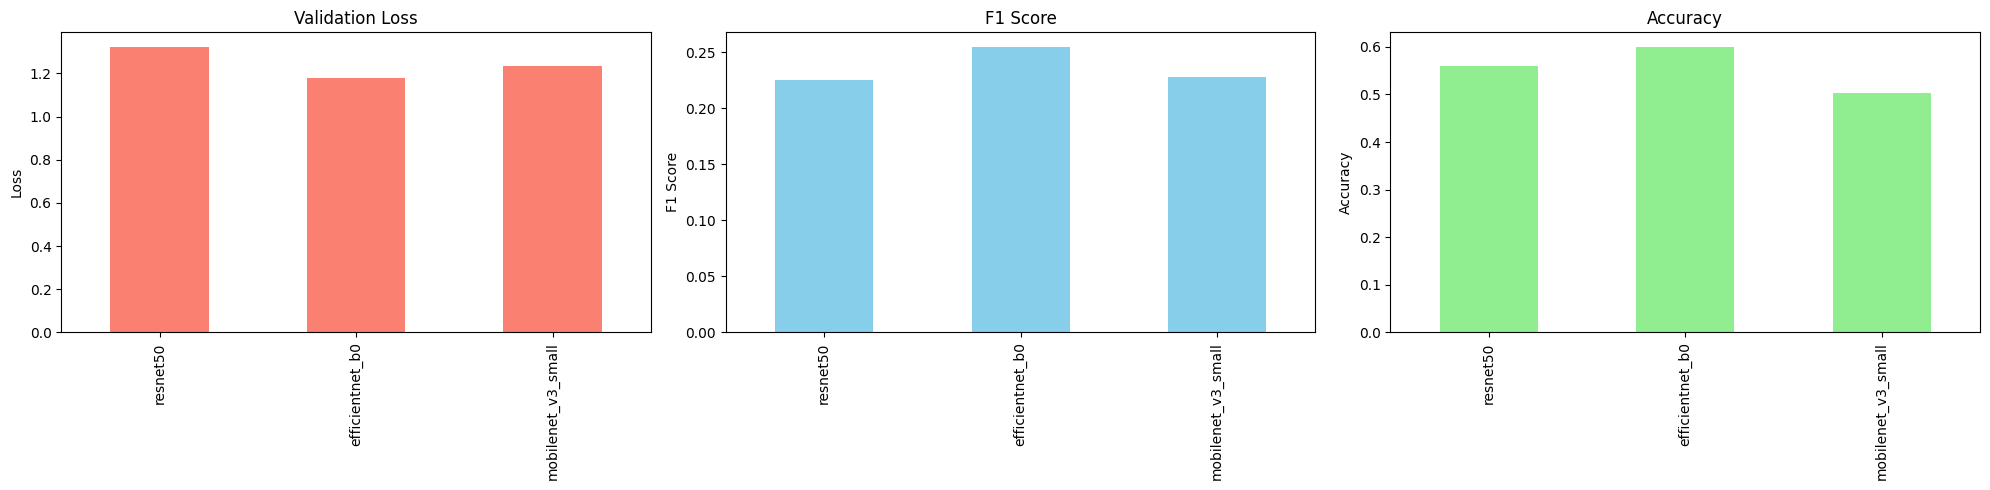

Final results and plots saved


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = ["resnet50", "efficientnet_b0", "mobilenet_v3_small"]
model_constructors = {
    "resnet50": models.resnet50,
    "efficientnet_b0": models.efficientnet_b0,
    "mobilenet_v3_small": models.mobilenet_v3_small
}

NUM_CLASSES = len(genre_to_idx)
criterion = nn.CrossEntropyLoss()

all_results = {}

for model_name in model_names:
    model = model_constructors[model_name](pretrained=False)

    if "resnet" in model_name:
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif "efficientnet" in model_name or "mobilenet" in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model.load_state_dict(torch.load(f"/kaggle/input/musicsheets/{model_name}_model.pth"))
    model = model.to(device)

    model.eval()
    val_losses, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = sum(val_losses) / len(val_losses)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
    accuracy = accuracy_score(all_labels, all_preds)

    all_results[model_name] = {
        "val_loss": avg_val_loss,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_accuracy": accuracy
    }

# Save results to a csv
results_df = pd.DataFrame(all_results).T
results_df.to_csv("final_model_evaluation.csv")
print(results_df)

# Plot loss, F1 Score, and accuracy
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Loss 
results_df['val_loss'].plot(kind='bar', ax=axes[0], color='salmon')
axes[0].set_title("Validation Loss")
axes[0].set_ylabel("Loss")

# F1 score
results_df['val_f1'].plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('F1 Score')
axes[1].set_ylabel("F1 Score")

# Accuracy
results_df['val_accuracy'].plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title("Accuracy")
axes[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.savefig("final_model_metrics.png")
plt.show()

print("Final results and plots saved")


# 4. Hyperparameter Tuning

## 4.1. Learning Rate Tuning

#### Run Section 1 & 2 and adjust LEARNING_RATE

### 4.1.1 Training

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Change parameters at the top of the notebook and run this cell

# Model configurations
model_names = ["efficientnet_b0"]
model_constructors = {
    # "resnet50": models.resnet50,
    "efficientnet_b0": models.efficientnet_b0,
    # "mobilenet_v3_small": models.mobilenet_v3_small
}

os.makedirs("saved_models", exist_ok=True)

for model_name in model_names:
    print(f"\nTraining {model_name}...")

    model = model_constructors[model_name](pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze convolutional layers
    for layer in model.features[-UNFROZEN_LAYERS:]:
        for param in layer.parameters():
            param.requires_grad = True


    # Adjust the output layer
    if "resnet" in model_name:
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif "efficientnet" in model_name or "mobilenet" in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"{model_name} Epoch {epoch+1}/{NUM_EPOCHS}") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.update(1)

        print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

    # Save trained model
    save_path = f"saved_models/{model_name}_{LEARNING_RATE}_model_{UNFROZEN_LAYERS}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Saved {model_name} to {save_path}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Using device: cuda

Training efficientnet_b0...


100%|██████████| 20.5M/20.5M [00:00<00:00, 87.1MB/s]
efficientnet_b0 Epoch 1/1:   1%|          | 8/821 [00:11<20:03,  1.48s/it]  


KeyboardInterrupt: 

### 4.1.2 Comparison of models with different hyperparameter values

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(genre_to_idx)
criterion = nn.CrossEntropyLoss()

# Path to your saved models
model_folder = "/kaggle/input/hyper/"

# Get all model paths
model_files = sorted([f for f in os.listdir(model_folder) if f.endswith('.pth')])

# Results dictionary
all_results = {}

for file_name in model_files:
    lr_match = re.search(r'b0_(\d\.\d+)_model', file_name)
    lr = lr_match.group(1) if lr_match else 'unknown'

    unfrozen_layers = 1 if "_1.pth" in file_name else 0
    model_key = f"LR_{lr}_Unfrozen_{unfrozen_layers}"

    # Load EfficientNet B0
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model.load_state_dict(torch.load(os.path.join(model_folder, file_name)))
    model = model.to(device)
    model.eval()

    val_losses, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = sum(val_losses) / len(val_losses)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
    accuracy = accuracy_score(all_labels, all_preds)

    all_results[model_key] = {
        "learning_rate": float(lr),
        "unfrozen_layers": unfrozen_layers,
        "val_loss": avg_val_loss,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_accuracy": accuracy
    }

# Save results to csv
results_df = pd.DataFrame.from_dict(all_results, orient='index').sort_values(by=['learning_rate', 'unfrozen_layers'])
results_df.to_csv("hyperparameter_results.csv", index=False)
print(results_df)

# Plot metrics
metrics = ['val_loss', 'val_f1', 'val_accuracy']
titles = ['Validation Loss', 'Validation F1 Score', 'Validation Accuracy']
colors = ['salmon', 'skyblue', 'lightgreen']

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    for unfrozen in [0, 1]:
        subset = results_df[results_df['unfrozen_layers'] == unfrozen]
        linestyle = '--' if unfrozen == 1 else '-'
        label = '1 Unfrozen Layer' if unfrozen == 1 else 'Output Only'
        ax.plot(subset['learning_rate'], subset[metric], linestyle=linestyle, marker='o', color=colors[idx], label=label)

    ax.set_xlabel("Learning Rate")
    ax.set_title(titles[idx])
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig("hyperparameter_comparison.png")
plt.show()

print("Hyperparameter evaluation done.")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/hyper/'

## 4.2 Unfrozen Layers Tuning

#### Run Section 1 & 2 and adjust UNFROZEN_LAYERS

### 4.2.1 Training

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NUM_CLASSES = len(genre_to_idx)

# Model configurations
model_names = ["efficientnet_b0"]
model_constructors = {
    # "resnet50": models.resnet50,
    "efficientnet_b0": models.efficientnet_b0,
    # "mobilenet_v3_small": models.mobilenet_v3_small
}

os.makedirs("saved_models", exist_ok=True)

for model_name in model_names:
    print(f"\nTraining {model_name}...")

    model = model_constructors[model_name](pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze convolutional layers
    for layer in model.features[-UNFROZEN_LAYERS:]:
        for param in layer.parameters():
            param.requires_grad = True


    # Adjust the output layer
    if "resnet" in model_name:
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif "efficientnet" in model_name or "mobilenet" in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"{model_name} Epoch {epoch+1}/{NUM_EPOCHS}") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.update(1)

        print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

    # Save trained model
    save_path = f"saved_models/{model_name}_{LEARNING_RATE}_model_{UNFROZEN_LAYERS}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Saved {model_name} to {save_path}")


### 4.2.2 Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(genre_to_idx)
criterion = nn.CrossEntropyLoss()

# Path to your saved models (exact Kaggle dataset path)
model_folder = "/kaggle/input/musicsheetsblanced/layers"

# Get all model files
model_files = sorted([f for f in os.listdir(model_folder) if f.endswith('.pth')])

# Store results
all_results = {}

# Loop through each model file
for file_name in model_files:
    # Extract learning rate and unfrozen layers from filename
    lr_match = re.search(r'b0_(\d\.\d+)_model', file_name)
    lr = lr_match.group(1) if lr_match else 'unknown'
    
    unfrozen_layers_match = re.search(r'model_(\d+)\.pth', file_name)
    unfrozen_layers = int(unfrozen_layers_match.group(1)) if unfrozen_layers_match else 0
    
    model_key = f"LR_{lr}_Unfrozen_{unfrozen_layers}"
    
    # Load EfficientNet-B0
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model.load_state_dict(torch.load(os.path.join(model_folder, file_name)))
    model = model.to(device)
    model.eval()

    val_losses, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = sum(val_losses) / len(val_losses)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
    accuracy = accuracy_score(all_labels, all_preds)

    all_results[model_key] = {
        "learning_rate": float(lr),
        "unfrozen_layers": unfrozen_layers,
        "val_loss": avg_val_loss,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_accuracy": accuracy
    }

# Save results to csv and print table
results_df = pd.DataFrame.from_dict(all_results, orient='index').sort_values(by=['unfrozen_layers'])
results_df.to_csv("layers_results.csv", index=False)
print("Metrics Table:")
print(results_df)

# Plot each metric in a clear bar chart comparing unfrozen layers
metrics = ['val_loss', 'val_f1', 'val_accuracy']
titles = ['Validation Loss', 'Validation F1 Score', 'Validation Accuracy']
colors = ['salmon', 'skyblue', 'lightgreen']

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.bar(
        results_df['unfrozen_layers'].astype(str),
        results_df[metric],
        color=colors[idx],
        width=0.6
    )
    ax.set_xlabel("Number of Unfrozen Layers")
    ax.set_ylabel(metric)
    ax.set_title(titles[idx])
    ax.grid(axis='y')

plt.tight_layout()
plt.savefig("layers_comparison.png")
plt.show()

print("Hyperparameter evaluation done.")


## 4.3 Batch-size Tuning

#### Run Section 1 & 2 and adjust BATCH_SIZE

### 4.3.1 Training

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NUM_CLASSES = len(genre_to_idx)

# Model configurations
model_names = ["efficientnet_b0"]
model_constructors = {
    # "resnet50": models.resnet50,
    "efficientnet_b0": models.efficientnet_b0,
    # "mobilenet_v3_small": models.mobilenet_v3_small
}

os.makedirs("saved_models", exist_ok=True)

for model_name in model_names:
    print(f"\nTraining {model_name}...")

    model = model_constructors[model_name](pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze convolutional layers
    for layer in model.features[-UNFROZEN_LAYERS:]:
        for param in layer.parameters():
            param.requires_grad = True


    # Adjust the output layer
    if "resnet" in model_name:
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif "efficientnet" in model_name or "mobilenet" in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"{model_name} Epoch {epoch+1}/{NUM_EPOCHS}") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.update(1)

        print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

    # Save trained model
    save_path = f"saved_models/{model_name}_{LEARNING_RATE}_model_{UNFROZEN_LAYERS}_{BATCH_SIZE}_aug.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Saved {model_name} to {save_path}")


### 4.3.2 Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(genre_to_idx)
criterion = nn.CrossEntropyLoss()

# Path to your saved models (adjusted to exact Kaggle dataset path)
model_folder = "/kaggle/input/musicsheetsblanced/batch"

# Get all model files
model_files = sorted([f for f in os.listdir(model_folder) if f.endswith('.pth')])

# Store results
all_results = {}

# Loop through each model file
for file_name in model_files:
    # Extract batch size from filename
    batch_size_match = re.search(r'model_\d+_(\d+)\.pth', file_name)
    batch_size = int(batch_size_match.group(1)) if batch_size_match else 'unknown'

    model_key = f"Batch_{batch_size}"

    # Load EfficientNet-B0
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model.load_state_dict(torch.load(os.path.join(model_folder, file_name)))
    model = model.to(device)
    model.eval()

    val_losses, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = sum(val_losses) / len(val_losses)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
    accuracy = accuracy_score(all_labels, all_preds)

    all_results[model_key] = {
        "batch_size": batch_size,
        "val_loss": avg_val_loss,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_accuracy": accuracy
    }

# Save results to CSV and print table
results_df = pd.DataFrame.from_dict(all_results, orient='index').sort_values(by=['batch_size'])
results_df.to_csv("batchsize_results.csv", index=False)
print("Metrics Table by Batch Size:")
print(results_df)

# Plot each metric as line chart clearly comparing batch sizes
metrics = ['val_loss', 'val_f1', 'val_accuracy']
titles = ['Validation Loss by Batch Size', 'Validation F1 Score by Batch Size', 'Validation Accuracy by Batch Size']
colors = ['salmon', 'skyblue', 'lightgreen']

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.plot(
        results_df['batch_size'],
        results_df[metric],
        marker='o',
        linestyle='-',
        color=colors[idx],
        linewidth=2
    )
    ax.set_xlabel("Batch Size")
    ax.set_ylabel(metric)
    ax.set_title(titles[idx])
    ax.set_xticks(results_df['batch_size'])
    ax.grid(True)

plt.tight_layout()
plt.savefig("batchsize_comparison.png")
plt.show()

print("Batch size evaluation and plots done.")


## 4.4 Augmentation Experiment

#### Run Section 1 & 2 and uncomment the Train Tranformation with augmentations

### 4.4.1 Training

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NUM_CLASSES = len(genre_to_idx)

# Model configurations
model_names = ["efficientnet_b0"]
model_constructors = {
    # "resnet50": models.resnet50,
    "efficientnet_b0": models.efficientnet_b0,
    # "mobilenet_v3_small": models.mobilenet_v3_small
}

os.makedirs("saved_models", exist_ok=True)

for model_name in model_names:
    print(f"\nTraining {model_name}...")

    model = model_constructors[model_name](pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    for layer in model.features[-UNFROZEN_LAYERS:]:
        for param in layer.parameters():
            param.requires_grad = True


    # Adjust the output layer
    if "resnet" in model_name:
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif "efficientnet" in model_name or "mobilenet" in model_name:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"{model_name} Epoch {epoch+1}/{NUM_EPOCHS}") as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.update(1)

        print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

    # Save trained model
    save_path = f"saved_models/{model_name}_{LEARNING_RATE}_model_{UNFROZEN_LAYERS}_{BATCH_SIZE}_aug.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Saved {model_name} to {save_path}")


### 4.4.2 Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(genre_to_idx)
criterion = nn.CrossEntropyLoss()

# Path to your saved models
model_folder = "/kaggle/input/musicsheetsblanced/aug"
model_files = sorted([f for f in os.listdir(model_folder) if f.endswith('.pth')])

# Store results
all_results = {}

for file_name in model_files:
    # Determine if model was trained with augmentation
    is_aug = "_aug" in file_name
    model_label = "With Augmentation" if is_aug else "No Augmentation"

    # Load model
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

    model.load_state_dict(torch.load(os.path.join(model_folder, file_name)))
    model = model.to(device)
    model.eval()

    val_losses, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = sum(val_losses) / len(val_losses)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
    accuracy = accuracy_score(all_labels, all_preds)

    all_results[model_label] = {
        "val_loss": avg_val_loss,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
        "val_accuracy": accuracy
    }

# Create DataFrame and save table
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df.to_csv("augmentation_comparison.csv")
print("Results Table:")
print(results_df)

# Plot comparison for each metric
metrics = ['val_loss', 'val_f1', 'val_accuracy']
titles = ['Validation Loss', 'Validation F1 Score', 'Validation Accuracy']
colors = ['salmon', 'skyblue', 'lightgreen']

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.bar(results_df.index, results_df[metric], color=colors[idx], width=0.6)
    ax.set_title(titles[idx])
    ax.set_ylabel(metric.replace("val_", "").capitalize())
    ax.set_xlabel("Model")
    ax.grid(axis='y')

plt.tight_layout()
plt.savefig("augmentation_effect_comparison.png")
plt.show()

print("Plots comparing augmentation vs no augmentation done.")


## 5. Resume Learning for a model

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training config
NUM_CLASSES = len(genre_to_idx)

# Load EfficientNet-B0 model (the best of the three)
model = models.efficientnet_b0(pretrained=False)

# Adjust classifier
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)

# Load previously saved weights
model_path = "/kaggle/input/musicsheets/efficientnet_b0_0.0001_model_3_32_aug_150ep.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 3 convolutional layers
for layer in model.features[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

# Ensure classifier is trainable
for param in model.classifier[-1].parameters():
    param.requires_grad = True

model = model.to(device)

# Define loss and optimizer (only trainable params)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f"Continue Epoch {epoch+1}/{NUM_EPOCHS}") as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)

    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}")

# Save model
os.makedirs("saved_models", exist_ok=True)
save_path = f"saved_models/efficientnet_b0_{LEARNING_RATE}_model_3_32_aug_160ep.pth"
torch.save(model.state_dict(), save_path)
print(f"Continued training complete. Model saved to {save_path}")


## 6. Model performance Across Training Epochs

In [ ]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(genre_to_idx)
criterion = nn.CrossEntropyLoss()

# Paths as saved in Kaggle
model_paths = [
    "/kaggle/input/musicsheets/efficientnet_b0_0.005_model_3_32_aug_20ep.pth",
    "/kaggle/input/musicsheets/efficientnet_b0_0.005_model_3_32_aug_50ep.pth",
    "/kaggle/input/musicsheets/efficientnet_b0_0.005_model_3_32_aug_80ep.pth",
    "/kaggle/input/musicsheets/efficientnet_b0_0.005_model_3_32_aug_100ep.pth",
    "/kaggle/input/musicsheets/efficientnet_b0_0.0005_model_3_32_aug_115ep.pth",
    "/kaggle/input/musicsheets/efficientnet_b0_0.0001_model_3_32_aug_150ep.pth"
]

# Extract epoch number from path
def extract_epoch(path):
    match = re.search(r"_([0-9]+)ep\.pth", path)
    return int(match.group(1)) if match else -1

# Store results
epoch_metrics = []

for path in sorted(model_paths, key=extract_epoch):
    epoch_num = extract_epoch(path)

    model = models.efficientnet_b0(pretrained=False)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    model.eval()

    val_losses, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = sum(val_losses) / len(val_losses)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
    accuracy = accuracy_score(all_labels, all_preds)

    epoch_metrics.append({
        "epoch": epoch_num,
        "val_loss": avg_val_loss,
        "val_f1": f1,
        "val_accuracy": accuracy
    })

df = pd.DataFrame(epoch_metrics).sort_values("epoch")

# Plot
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(df["epoch"], df["val_loss"], marker='o', color='salmon')
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(df["epoch"], df["val_f1"], marker='o', color='skyblue')
plt.title("Validation F1 Score vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.subplot(1, 3, 3)
plt.plot(df["epoch"], df["val_accuracy"], marker='o', color='lightgreen')
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig("epoch_trend_aug_model.png")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(genre_to_idx)
criterion = nn.CrossEntropyLoss()

model_path = "/kaggle/input/musicsheets/efficientnet_b0_0.0001_model_3_32_aug_150ep.pth"
model = models.efficientnet_b0(pretrained=False)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Evaluate on test set
test_losses = []
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
avg_loss = sum(test_losses) / len(test_losses)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")
accuracy = accuracy_score(all_labels, all_preds)

# Print
print(f"Test Loss: {avg_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# -----------------------------
# Table of Metrics as Image
# -----------------------------
metrics_df = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score", "Precision", "Recall"],
    "Value": [avg_loss, accuracy, f1, precision, recall]
})

# Save CSV (optional for download)
metrics_df.to_csv("test_metrics_summary.csv", index=False)

# Plot as table image
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
tbl = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
tbl.scale(1, 2)
plt.title("Test Set Performance Summary", fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("test_metrics_summary.png")
plt.show()

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
labels = [idx_to_genre[i] for i in range(NUM_CLASSES)]

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels), 
            annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()
